In [1]:
%run PreProcessing.ipynb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import *
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import Pipeline

Current Progress: 100.0 %


In [82]:
enc = OrdinalEncoder()
encoded_df = enc.fit_transform(summary_data_avg[['method', 'variety', 'inputs', 'protection']])
summary_data_avg[['method', 'variety', 'inputs', 'protection']] = encoded_df

In [83]:
X = summary_data_avg[['heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']]
print(X.head())
y = summary_data_avg['mean_diameter']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

   heat_units  solar_radiation  organic_matter  sand  silt  clay  method  \
0        1970          1073585            24.6    40    41    19     2.0   
1        2641          1247965            24.6    40    41    19     2.0   
2        3189          1379555            24.6    40    41    19     2.0   
3        3540          1529793            24.6    40    41    19     2.0   
4        3813          1631446            24.6    40    41    19     2.0   

   variety  inputs  protection  
0     11.0     1.0         0.0  
1     11.0     1.0         0.0  
2     11.0     1.0         0.0  
3     11.0     1.0         0.0  
4     11.0     1.0         0.0  


In [84]:
#Isolation forest algorithm to show unsupervised learning
from sklearn.ensemble import IsolationForest

print(f"The old training dataframe shape: {X_train.shape}")

#Use the algorithm for outlier detection, then use it to predict each point
clf1 = IsolationForest(max_samples=500, random_state = 10, contamination= 'auto')
preds = clf1.fit_predict(X_train)

#Any point labelled as -1 is an outlier
totalOutliers=0
for pred in preds:
    if pred == -1:
        totalOutliers=totalOutliers+1
print("Total number of outliers identified is: ",totalOutliers)

The old training dataframe shape: (2686, 10)
Total number of outliers identified is:  789


In [85]:
#Remove outliers from training data.
filtered_array = []
for element in preds:
  if element != -1:
    filtered_array.append(True)
  else:
    filtered_array.append(False)
X_train = X_train[filtered_array]
y_train = y_train[filtered_array]

print(f"The new training dataframe shape: {X_train.shape}")

The new training dataframe shape: (1897, 10)


In [86]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
param_grid = {'random_state': [10],
              'max_features': ['sqrt', 'auto', 'log2']}  
   
grid_rfr = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid_rfr.fit(X_train_scaled, y_train.values.ravel()) 
 
# print best parameter after tuning 
print(grid_rfr.best_params_) 
grid_rfr_preds = grid_rfr.predict(X_test_scaled)  


rfr = RandomForestRegressor(max_features = 'sqrt')
rfr_model = rfr.fit(X_train_scaled, y_train.values.ravel())
rfr_model_pred = rfr_model.predict(X_test_scaled)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'max_features': 'sqrt', 'random_state': 10}


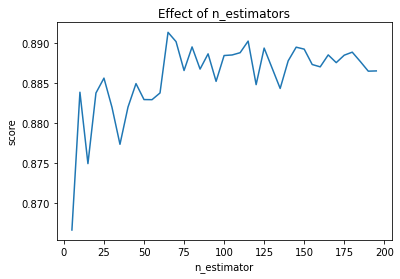

In [100]:
estimators = np.arange(5, 200, 5)
scores = []
for n in estimators:
    rfr.set_params(n_estimators=n)
    rfr.fit(X_train_scaled, y_train)
    scores.append(rfr.score(X_test_scaled, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

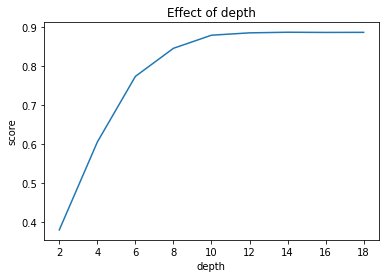

In [101]:
depth = np.arange(2, 20, 2)
scores = []
for n in depth:
    rfr.set_params(max_depth=n)
    rfr.fit(X_train_scaled, y_train)
    scores.append(rfr.score(X_test_scaled, y_test))
plt.title("Effect of depth")
plt.xlabel("depth")
plt.ylabel("score")
plt.plot(depth, scores)

In [90]:
y_test_df = y_test.to_frame()
y_test_df = y_test_df.rename(columns = {0:'mean_diameter'}).reset_index(drop=True)
pred_df = pd.DataFrame(rfr_model_pred, columns = ['predicted_mean_diameter']).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test, columns = ['heat_units', 'solar_radiation', 'organic_matter', 'sand', 'silt', 'clay', 'method', 'variety', 'inputs', 'protection']).reset_index(drop=True)

In [91]:
test_df = X_test_df.copy()
test_df['predicted_mean_diameter'] = pd.Series(pred_df['predicted_mean_diameter'])
test_df['mean_diameter'] = pd.Series(y_test_df['mean_diameter'])
test_df.head()

,heat_units,solar_radiation,organic_matter,sand,silt,clay,method,variety,inputs,protection,predicted_mean_diameter,mean_diameter
0,4090,1770870,29.6,39,37,24,2.0,2.0,1.0,0.0,28.083118,26.919200
1,3531,1425903,69.8,38,52,10,2.0,4.0,1.0,0.0,26.344966,30.121481
2,3208,1361678,26.7,22,55,23,2.0,4.0,1.0,0.0,11.614113,8.832000
3,3365,1537170,20.0,63,15,22,2.0,16.0,1.0,0.0,24.116021,23.685106
4,3960,1585751,19.9,31,36,33,2.0,14.0,1.0,0.0,26.973092,24.416800


<AxesSubplot:xlabel='predicted_mean_diameter', ylabel='mean_diameter'>

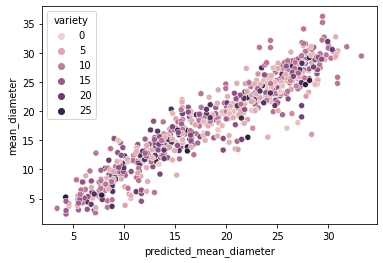

In [92]:
sns.scatterplot(y = 'mean_diameter', x = 'predicted_mean_diameter', hue = 'variety', data = test_df)

<AxesSubplot:xlabel='solar_radiation', ylabel='mean_diameter'>

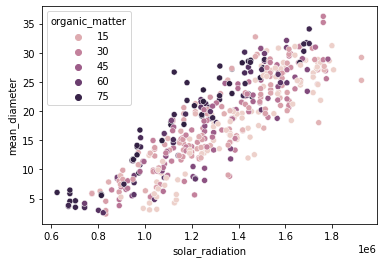

In [105]:
sns.scatterplot(y = 'mean_diameter', x = 'solar_radiation', hue = 'organic_matter', data = test_df[(test_df.method == 2)])